# Event Picker

This notebook allows to inspect the results from the clustering and estimation phases of Spyral, by displaying the locations of the tracks on the kinematics and PID plots, and showing the point cloud with the cluster determination. The clustering phase groups points from the point cloud into clusters, and the estimation phase determines the kinematical and energy loss for each of these clusters. If the estimation phase fails for a particular cluster, there is no corresponding track data recorded and the cluster is simply dropped. This explains why there can be more clusters than tracks.

When clicking somewhere on the kinematics or the PID plot, the closest data point of a particular track is picked and the event to which it belongs is displayed, as well as the data from other tracks of that event if there are any. The color scheme is consistent between all the plots, which helps in identifying which particles are involved in a given event.

This version handles only one run that has to be specified. The workspace path where all the Spyral files are located also needs to be specified.

In [6]:
from spyral.core.point_cloud import PointCloud
from spyral.core.cluster import Cluster

import h5py as h5
import polars as pl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib widget
plt.close()

workspace_path = Path("/Volumes/researchEXT/O16/no_efield/no_field_fitracks_v1.0/")
cloud_path = workspace_path / "Pointcloud"
cluster_path = workspace_path / "Cluster"
estimation_result_path = workspace_path / "Estimation"
df = None
run = 54 # Your run number
path = estimation_result_path / f"run_{run:04d}.parquet"
cloud_file_path = cloud_path / f"run_{run:04d}.h5"
cloud_file = h5.File(cloud_file_path, 'r')
cloud_group: h5.Group = cloud_file.get('cloud')
cluster_file_path = cluster_path / f"run_{run:04d}.h5"
cluster_file = h5.File(cluster_file_path, 'r')
cluster_group: h5.Group = cluster_file.get('cluster')

df = pl.scan_parquet(path)
df = df.collect()


In [7]:
df

event,cluster_index,cluster_label,orig_run,orig_event,ic_amplitude,ic_centroid,ic_integral,ic_multiplicity,vertex_x,vertex_y,vertex_z,center_x,center_y,center_z,polar,azimuthal,brho,dEdx,sqrt_dEdx,dE,arclength,direction
i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
38032,1,1,54,38032,-1.0,-1.0,-1.0,-1.0,12.226418,-10.180269,634.089542,83.895541,-69.832144,634.089542,0.411381,4.018247,0.699563,1944.865648,44.100631,724054.543198,372.290263,0
38032,2,0,54,38032,-1.0,-1.0,-1.0,-1.0,-4.086402,18.479149,722.825008,-11.293358,51.059674,722.825008,0.142972,0.217699,0.702561,4201.515392,64.819097,2.4156e6,574.939462,0
38036,1,2,54,38036,-1.0,-1.0,-1.0,-1.0,15.614357,-2.577488,-74.390369,106.960565,-17.637344,-74.390369,0.238569,4.548993,1.175299,1278.505525,35.756196,35365.949252,27.661945,0
38052,0,2,54,38052,-1.0,-1.0,-1.0,-1.0,0.197539,-6.528898,826.79311,3.035861,-101.751816,826.79311,0.726109,3.171391,0.430438,5284.637127,72.69551,950498.0,179.860599,0
38084,0,0,54,38084,-1.0,-1.0,-1.0,-1.0,6.391963,-12.884869,749.609661,69.152056,-139.354358,749.609661,0.51975,3.602233,0.852804,1097.05049,33.121753,292554.765829,266.67393,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
82527,0,0,54,82527,-1.0,-1.0,-1.0,-1.0,-3.665542,3.565094,554.213263,-13.243836,12.881153,554.213263,0.066567,0.799276,0.602614,4503.15471,67.105549,1.8194e6,404.019386,0
82527,1,1,54,82527,-1.0,-1.0,-1.0,-1.0,1.944846,-1.100591,926.694801,-66.002923,37.424945,926.694801,1.182225,1.055004,0.253205,1740.351808,41.717524,95150.365149,54.673064,0
82559,0,0,54,82559,-1.0,-1.0,-1.0,-1.0,-5.282509,-10.993828,722.425002,-101.286952,-210.735372,722.425002,0.929866,2.69355,0.829462,1937.636568,44.018593,330755.980032,170.700732,0


In [24]:
event_counts = df.group_by("event").count()
events_5 = event_counts.filter(pl.col("count") == 5)
filtered_df = df.join(events_5, on="event", how="inner")

/var/folders/5q/ngq_6gg50c35p7kqrqgnwmzw0000gs/T/ipykernel_35893/2705738483.py:1: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  event_counts = df.group_by("event").count()


In [25]:
filtered_df

event,cluster_index,cluster_label,orig_run,orig_event,ic_amplitude,ic_centroid,ic_integral,ic_multiplicity,vertex_x,vertex_y,vertex_z,center_x,center_y,center_z,polar,azimuthal,brho,dEdx,sqrt_dEdx,dE,arclength,direction,count
i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,u32


['event', 'cluster_index', 'cluster_label', 'orig_run', 'orig_event', 'ic_amplitude', 'ic_centroid', 'ic_integral', 'ic_multiplicity', 'vertex_x', 'vertex_y', 'vertex_z', 'center_x', 'center_y', 'center_z', 'polar', 'azimuthal', 'brho', 'dEdx', 'sqrt_dEdx', 'dE', 'arclength', 'direction']


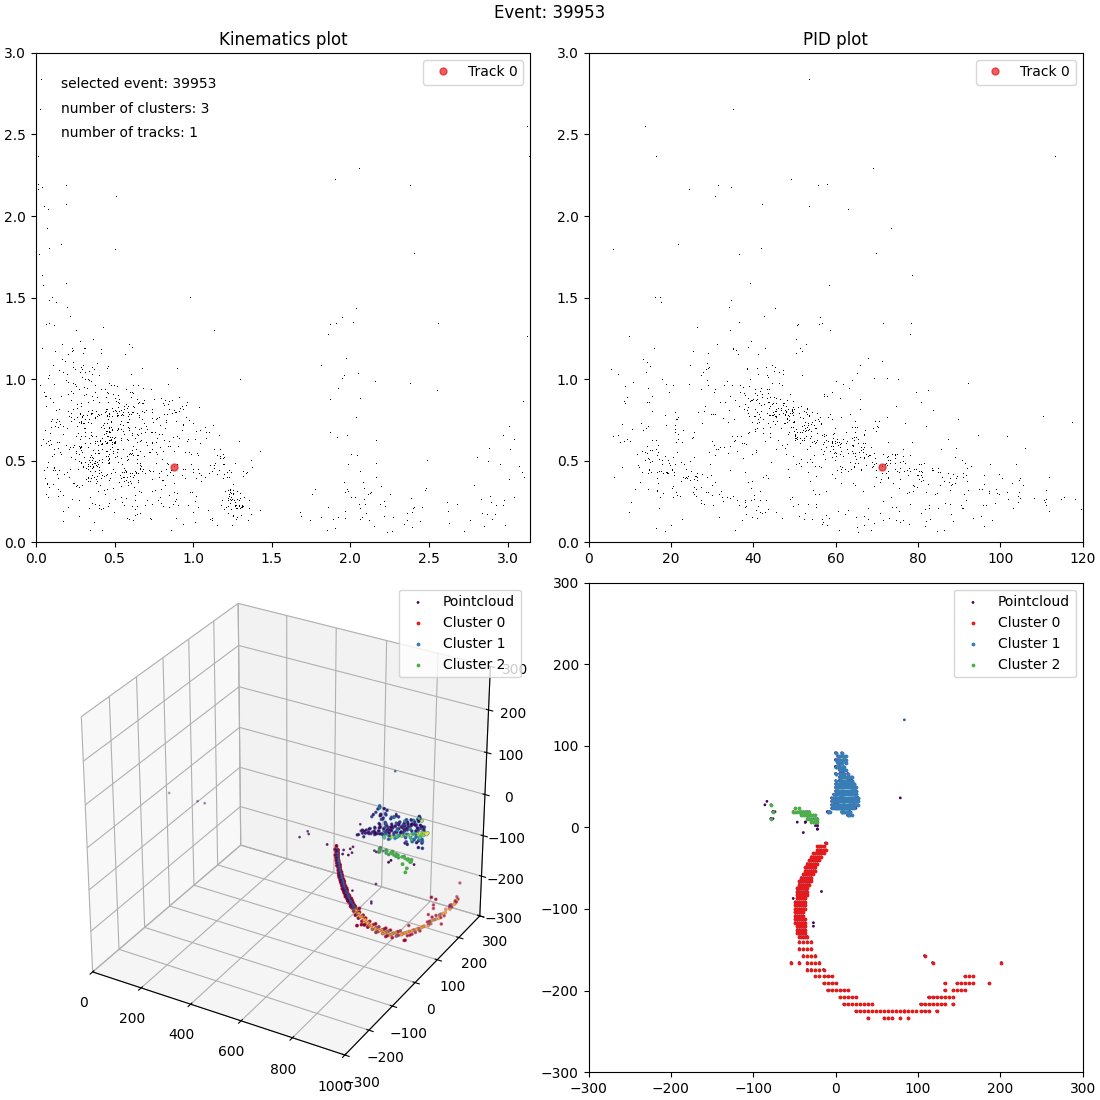

In [23]:
class PointBrowser:

    def __init__(self):
        self.lastind = 0

        self.text = axs["C"].text(0.05, 0.95, 'selected event: none', transform=axs["C"].transAxes, va='top')
        self.tracks = axs["C"].text(0.05, 0.85, 'number of tracks: 0', transform=axs["C"].transAxes, va='top')
        self.clusters = axs["C"].text(0.05, 0.90, 'number of clusters: 0', transform=axs["C"].transAxes, va='top')
        self.marker1, = [axs["C"].plot(xs[0], ys[0], 'o', ms=5, alpha=0.7, color=cmap(0.0), visible=False)]
        self.marker2, = [axs["D"].plot(xs[0], ys[0], 'o', ms=5, alpha=0.7, color=cmap(0.0), visible=False)]
        for i in range(1,10):
            art, = axs["C"].plot(xs[i], ys[i], 'o', ms=5, alpha=0.7, color=cmap(float(i)/9.0), visible=False)
            self.marker1.append(art)
            art, = axs["D"].plot(xs[i], ys[i], 'o', ms=5, alpha=0.7, color=cmap(float(i)/9.0), visible=False)
            self.marker2.append(art)

    def on_pick(self, event):

        if event.artist != line and event.artist != line2:
            return True

        N = len(event.ind)
        if not N:
            return True

        # the click locations
        x = event.mouseevent.xdata
        y = event.mouseevent.ydata

        if event.artist == line:
            distances = np.hypot(x - xs[event.ind], y - ys[event.ind])
        elif event.artist == line2:
            distances = np.hypot(x - de[event.ind], y - ys[event.ind])
        indmin = distances.argmin()
        dataind = event.ind[indmin]

        self.lastind = dataind
        self.update()

    def update(self):
        if self.lastind is None:
            return

        dataind = self.lastind
        event = ev[dataind]
        self.update_plots(event)

    def update_plots(self, event):
        event_data = cloud_group[f'cloud_{event}']
        cloud = PointCloud(event, event_data[:].copy())

        axs["A"].clear()
        axs["B"].clear()
        axs["A"].scatter(cloud.data[:, 2], cloud.data[:, 0], cloud.data[:, 1], c=cloud.data[:, 3], s=1, label="Pointcloud")
        axs["A"].set_xlim3d(0., 1000.0)
        axs["A"].set_ylim3d(-300.0, 300.0)
        axs["A"].set_zlim3d(-300.0, 300.0)
        axs["B"].scatter(cloud.data[:, 0], cloud.data[:, 1], c=cloud.data[:, 3], s=1, label="Pointcloud")
        axs["B"].set_xlim(-300.0, 300.0)
        axs["B"].set_ylim(-300.0, 300.0)
    
        self.text.set_text('selected event: %d' % event)
        tracks = (ev == event).sum()
        self.tracks.set_text('number of tracks: %d' % tracks)
        ind, = np.where(ev == event)
        for i in range(tracks):
            self.marker1[i].set_data([xs[ind[i]]], [ys[ind[i]]])
            self.marker1[i].set_visible(True)
            self.marker1[i].set_color(cmap(float(cl[ind[i]])/9.0))
            self.marker1[i].set_label(f"Track {i}")
            self.marker2[i].set_data([de[ind[i]]], [ys[ind[i]]])
            self.marker2[i].set_color(cmap(float(cl[ind[i]])/9.0))
            self.marker2[i].set_visible(True)
            self.marker2[i].set_label(f"Track {i}")
        for i in range(tracks,10):
            self.marker1[i].set_visible(False)
            self.marker2[i].set_visible(False)
            self.marker1[i].set_label(f"_Track {i}")
            self.marker2[i].set_label(f"_Track {i}")
        axs["C"].legend()
        axs["D"].legend()

        clusters = cluster_group[f'event_{event}']
        nclusters = clusters.attrs["nclusters"]

        self.clusters.set_text('number of clusters: %d' % nclusters)
        for i in range(nclusters):
            cluster = clusters[f'cluster_{i}']
            cluster_cloud = cluster['cloud']
            cluster_data = Cluster(event, i, cluster.attrs["direction"], cluster_cloud[:].copy())
            axs["A"].scatter(cluster_data.data[:, 2], cluster_data.data[:, 0], cluster_data.data[:, 1], color=cmap(float(i)/9.0), s=3, label=f"Cluster {cluster_data.label}")
            axs["B"].scatter(cluster_data.data[:, 0], cluster_data.data[:, 1], color=cmap(float(i)/9.0), s=3, label=f"Cluster {cluster_data.label}")
        axs["A"].legend()
        axs["B"].legend()

        fig.canvas.draw()

plt.close()
cols = df.columns
print(cols)
ev = np.array(df['event'])
ys = np.array(df['brho'])
xs = np.array(df["polar"])
de = np.array(df["sqrt_dEdx"])
cl = np.array(df["cluster_label"])

cmap = plt.cm.Set1

fig, axs = plt.subplot_mosaic(
    """
    CD
    AB
    """,
    per_subplot_kw={
        "A": {
            "projection": "3d", 
            "box_aspect": (1,1,1),
            "aspect": "equalxy"
        }
    },
    figsize=(11.0, 11.0),
    constrained_layout=True
)

line, = axs["C"].plot(xs, ys, ',', color="black", markeredgecolor=None, picker=True, pickradius=5)
axs["C"].set_title('Kinematics plot')
axs["C"].set_xlim(0.0, np.pi)
axs["C"].set_ylim(0.0, 3.0)

line2, = axs["D"].plot(de, ys, ',', color="black", markeredgecolor=None, picker=True, pickradius=5)
axs["D"].set_title('PID plot')
axs["D"].set_xlim(0.0, 120.0)
axs["D"].set_ylim(0.0, 3.0)

browser = PointBrowser()
fig.canvas.mpl_connect('pick_event', browser.on_pick)

event = 39953
browser.update_plots(event)
plt.suptitle(f"Event: {event}")
plt.show()